### Продвинутая визуализация данных. Задания 4
В этот раз нам нужно создать визуализации результатов работы алгоритмов обучения с учителем и без учителя, проанализировать изменения параметров и ROC-кривых при изменении гиперпараметров модели, обсудить различия в результатах работы моделей.

Мы будем работать с тремя датасетами. Перед каждым заданием будет его описание.

Не пугайтесь количеству импортированных библиотек — это шпаргалка со всеми библиотеками, которые мы использовали в четвертом модуле. В этом задании мы будем использовать несколько из них.

In [22]:
#импорт библиотек

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS

Первый датасет — данные по весу и росту в зависимости от пола. В нем нет разметки, поэтому необходимо использовать методы обучения без учителя.

Импортируем датасет и визуально посмотрим на него перед началом работы:

In [23]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


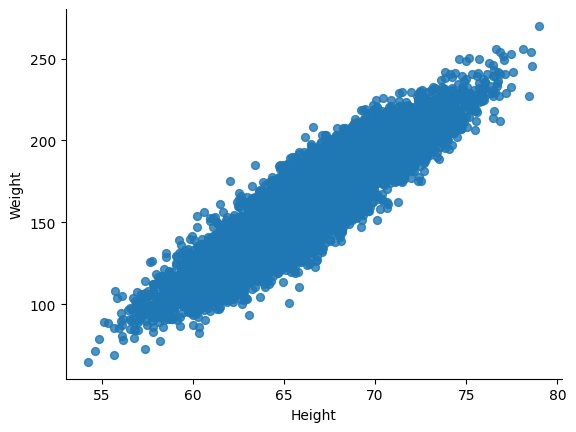

In [24]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Задание 1. Сравнение моделей обучения с учителем (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

Interquartile range (IQR) — возьмите выбросы по x и y.
Isolation forest.
Local Outlier Factor.
One-class SVM.
Gaussian Mixture.
DBSCAN.
Напишите, какие модели показали себя лучше всего и почему.

Критерии оценивания:

1 балл за каждую правильно построенную модель и корректно выведенные выбросы (всего 3 балла).
1 балл за правильное оформление графиков и полотна графиков.

Задания 2 и 3
Используя датасет, определите оптимальные параметры модели Isolation Forest с помощью кросс-валидации.

Наш датасет — это набор данных, первоначально взятый из набора данных UCI о заболеваниях щитовидной железы. Он содержит 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут. Всего — 22 атрибута.

In [25]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


### Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
Сделайте предсказания на данных Х.
Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).
Критерии оценивания:

1 балл за правильное использование GridSearchCV для подбора параметров в IsolationForest.
2 балла за правильный вывод параметров для шести моделей с разным параметром n_jobs.

### Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.

Критерии оценивания:

2 балла за правильно построенные визуализации ROC-кривой.
1 балл за вывод правильных F1-score, Precision, Recall.

### Задание 4. Проверка эффективности моделей без учителя (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (cgpa) и балл за экзамен (placement_exam_marks), а в качестве зависимой переменной в кластеризации используйте переменную placed.

Создайте поле из шести графиков. Каждый график должен представлять собой confusion_matrix (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

k-Nearest Neighbors (KNN).
SVM (Support Vector Machine).
Random Forest.
AdaBoost.
Gradient Boosting.
Decision Tree.
Критерии оценивания:

1 балл за каждые 2 правильно построенные модели и корректно выведенные выбросы.
1 балл за правильное оформление графиков и полотна графиков.

In [26]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0
